In [1]:
# DOWNLOADS THE DATA FROM THE ECMWF

from ecmwfapi import ECMWFDataServer
    
server = ECMWFDataServer()
    
server.retrieve({
    'stream'    : "oper",
    'levtype'   : "sfc",
    'param'     : "151.128",
    'dataset'   : "interim",
    'step'      : "0",
    'area'      : "45/-140/75/-105",
    'grid'      : "0.75/0.75",
    'time'      : "00/06/12/18",
    'date'      : "2000-01-01/to/2019-01-01",
    'type'      : "an",
    'class'     : "ei",
    'format'    : "netcdf",
    'target'    : "AB_interim_2000_01_01to2019_01_01.nc"
 })

2020-06-11 09:10:58 ECMWF API python library 1.5.0
2020-06-11 09:10:58 ECMWF API at https://api.ecmwf.int/v1
2020-06-11 09:10:59 Welcome Jeffrey Rawlyk
2020-06-11 09:11:00 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2020-06-11 09:11:01 Request submitted
2020-06-11 09:11:01 Request id: 5ee2498573e7d490ad61d195
2020-06-11 09:11:01 Request is submitted
2020-06-11 09:11:03 Request is queued
2020-06-11 09:11:09 Request is active
    REPRES     = SH,
    LEVTYPE    = SFC,
    PARAM      = 151.128,
    TIME       = 0000/0600/1200/1800,
    STEP       = 0,
    DOMAIN     = G,
    RESOL      = AUTO,
    AREA       = 75/-140/45/-105,
    GRID       = 0.75/0.75,
    PADDING    = 0,
    DATE       = 20181101/20181102/20181103/20181104/20181105/20181106/20181107/20181108/20181109/20181110/20181111/20181112/20181113/20181114/20181115/20181116/20181117/20181118/20181119/20181120/20181121/20181122/20181123/20181124/20181125

In [2]:
#import necessary packages

import numpy as np
import os as os
import sys as sys
from numpy import ma
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA as pca
from sklearn import preprocessing

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from IPython.display import Image
from datetime import datetime, timedelta


In [1]:
#set a random seed to ensure reproducibility of results
np.random.seed(42)

NameError: name 'np' is not defined

In [6]:
# read in the dataset and view it
dset = xr.open_mfdataset('AB_interim_2000_01_01to2019_01_01.nc')
dset

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [8]:
#select the time for the data
dset = dset.sel(time=slice('2000-1-1','2018-12-31'))

#find mean and standardize data
dsetm = dset.mean('time')/100
msl = dset['msl'].values/100

In [ ]:
#set the coordinate range
lat = dset.latitude
lon = dset.longitude
lons, lats = np.meshgrid(lon, lat)
central_longitude = 180.

#set the mapping projection
proj = ccrs.PlateCarree(central_longitude=central_longitude)

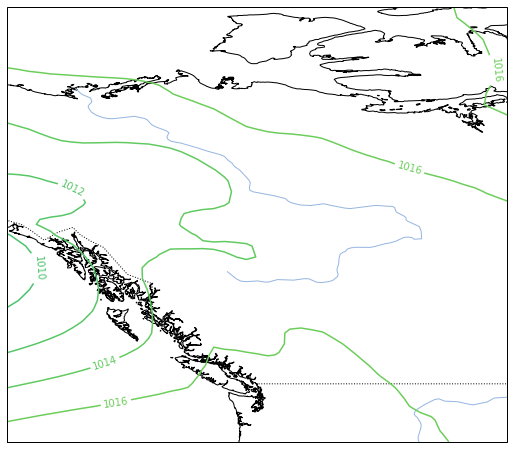

In [31]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})

ax.coastlines('10m')

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.RIVERS)

c = ax.contour(lons - central_longitude, lats, dsetm['msl'], np.arange(940, 1040, 2))

plt.clabel(c, fmt='%i')

ax.set_extent([lon.data.min() - central_longitude, lon.data.max() - central_longitude, lat.data.min(), lat.data.max()], crs=proj)

In [32]:
def make_map(X, lons, lats, vmin=930, vmax=1040, step=2, ax=None, central_longitude=180., fmt='%i'): 
    
    from numpy import ma
    
    if not(ax): 
        central_longitude = 180.
        proj = ccrs.PlateCarree(central_longitude=central_longitude)
        f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})
        
    proj = ccrs.PlateCarree(central_longitude=central_longitude)
    
    ax.coastlines('10m')
            
    if X.min() < 0 and X.max() > 0: 
        p = ax.contour(lons - central_longitude, lats, ma.masked_less(X,0), np.arange(0, vmax + step, step), colors='r')
        n = ax.contour(lons - central_longitude, lats, ma.masked_greater(X,0), np.arange(vmin, 0, step), colors='b')
        
        ax.contour(lons - central_longitude, lats, X, np.array([0]), colors='k')
        
        plt.clabel(p, fmt=fmt)
        plt.clabel(n, fmt=fmt) 
    elif X.min() < 0 and X.max() < 0: 
        n = ax.contour(lons - central_longitude, lats, X, np.arange(vmin, vmax + step, step), colors='b')
        plt.clabel(n, fmt=fmt)
    else: 
        p = ax.contour(lons - central_longitude, lats, X, np.arange(vmin, vmax + step, step), colors='r')
        plt.clabel(p, fmt=fmt)        
                            
    ax.set_extent([lon.data.min() - central_longitude, lon.data.max() - central_longitude, lat.data.min(), lat.data.max()], crs=proj)

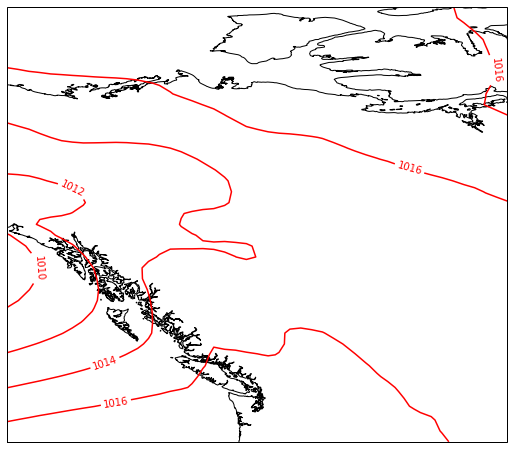

In [33]:
make_map(dsetm['msl'].data, lons, lats)

In [34]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 47, time: 27760)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.25 -138.5 ... -106.25 -105.5
  * latitude   (latitude) float32 75.0 74.25 73.5 72.75 ... 46.5 45.75 45.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2018-12-31T18:00:00
Data variables:
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(27760, 41, 47), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-11 15:37:13 GMT by grib_to_netcdf-2.16.0: grib_to_n...

In [37]:
msl = dset['msl']
msl

In [39]:
# go from 3D (time, lat, lon) to 2D (time, space) to perform the Principal Component Analysis
msl_stacked = msl.stack(latlon=('latitude', 'longitude'))
msl_stacked

In [41]:
msl.shape

(27760, 41, 47)

In [42]:
#make sure it is in 2 dimensions
msl_stacked.shape

(27760, 1927)

In [43]:
type(msl_stacked.data)

dask.array.core.Array

In [44]:
#load the dataset in the memory to perform the PCA
msl_stacked.load()

<xarray.DataArray 'msl' (time: 27760, latlon: 1927)>
array([[ 99982.414,  99936.445,  99895.13 , ..., 101373.35 , 101389.17 ,
        101407.66 ],
       [100170.79 , 100123.484, 100083.84 , ..., 101101.02 , 101188.13 ,
        101290.07 ],
       [100632.16 , 100595.016, 100561.375, ..., 100800.555, 100797.555,
        100854.016],
       ...,
       [100083.516, 100108.   , 100134.65 , ..., 102420.01 , 102134.52 ,
        101879.85 ],
       [100031.38 , 100044.375, 100059.36 , ..., 103376.22 , 103238.81 ,
        103111.56 ],
       [ 99862.49 ,  99869.15 ,  99876.15 , ..., 103967.17 , 103870.234,
        103775.97 ]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2018-12-31T18:00:00
  * latlon     (latlon) MultiIndex
  - latitude   (latlon) float64 75.0 75.0 75.0 75.0 75.0 ... 45.0 45.0 45.0 45.0
  - longitude  (latlon) float64 -140.0 -139.2 -138.5 ... -107.0 -106.2 -105.5
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level

In [45]:
type(msl_stacked.data)

numpy.ndarray

In [46]:
X = msl_stacked.data

In [47]:
X.shape

(27760, 1927)

In [48]:
type(X)

numpy.ndarray

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
scaler  = StandardScaler()

In [51]:
scaler = scaler.fit(X)

In [52]:
X = scaler.transform(X)

In [53]:
X.shape

(27760, 1927)

In [54]:
X.mean(0)

array([ 1.7769741e-08, -1.9358627e-08,  7.0610895e-08, ...,
        5.2355894e-08,  2.3592790e-08,  5.1849170e-08], dtype=float32)

In [55]:
X.mean()

8.2150724e-11

In [56]:
X.std(0)

array([0.99999905, 0.9999992 , 0.9999969 , ..., 0.9999996 , 0.99999857,
       0.9999985 ], dtype=float32)

In [57]:
from sklearn.decomposition import pca

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [58]:
skpca = pca.PCA()

In [59]:
skpca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

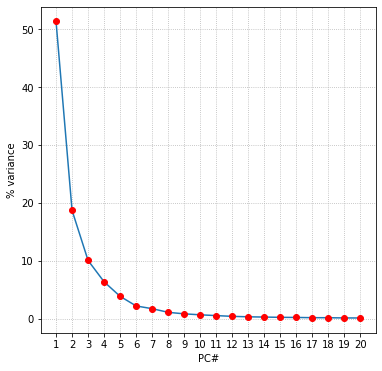

In [60]:
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), skpca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), skpca.explained_variance_ratio_[0:20]*100,'ro')
ax.grid(ls=':')
ax.set_xticks(range(1,21)); 
ax.set_xlabel('PC#');
ax.set_ylabel("% variance");

In [65]:
ipc = 5

In [66]:
skpca.explained_variance_ratio_[:ipc].sum()

0.9022676

In [67]:
PCs = skpca.transform(X)

In [68]:
PCs = PCs[:,:ipc]
PCs.shape

(27760, 5)

In [69]:
type(PCs)

numpy.ndarray

In [ ]:
#THE EOF'S CONTAIN THE SPATIAL PATTERNS OF THE PCA's

In [70]:
EOFs = skpca.components_

In [71]:
EOFs = EOFs[:ipc,:]

In [72]:
EOFs.shape

(5, 1927)

In [73]:
EOFs_r = EOFs.reshape((ipc, len(lat), len(lon)))

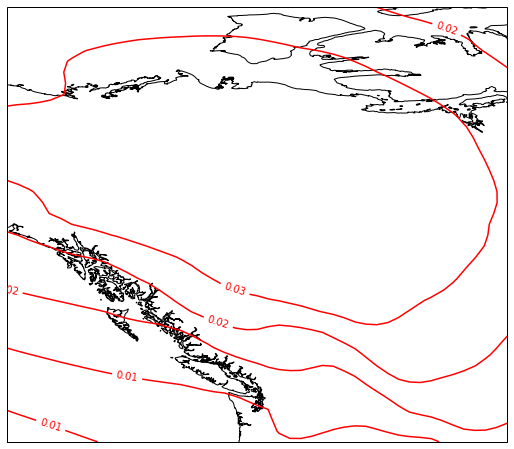

In [74]:
make_map(EOFs_r[0,:,:], lons, lats, vmin=-1, vmax=1, step=0.005, fmt='%4.2f')

In [75]:
time = dset['time']

In [76]:
time

<xarray.DataArray 'time' (time: 27760)>
array(['2000-01-01T00:00:00.000000000', '2000-01-01T06:00:00.000000000',
       '2000-01-01T12:00:00.000000000', ..., '2018-12-31T06:00:00.000000000',
       '2018-12-31T12:00:00.000000000', '2018-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2018-12-31T18:00:00
Attributes:
    long_name:  time

In [77]:
timeindex = time.to_index()

In [78]:
timeindex

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 06:00:00',
               '2000-01-01 12:00:00', '2000-01-01 18:00:00',
               '2000-01-02 00:00:00', '2000-01-02 06:00:00',
               '2000-01-02 12:00:00', '2000-01-02 18:00:00',
               '2000-01-03 00:00:00', '2000-01-03 06:00:00',
               ...
               '2018-12-29 12:00:00', '2018-12-29 18:00:00',
               '2018-12-30 00:00:00', '2018-12-30 06:00:00',
               '2018-12-30 12:00:00', '2018-12-30 18:00:00',
               '2018-12-31 00:00:00', '2018-12-31 06:00:00',
               '2018-12-31 12:00:00', '2018-12-31 18:00:00'],
              dtype='datetime64[ns]', name='time', length=27760, freq=None)

In [79]:
PCdf = pd.DataFrame(PCs, index = timeindex, columns = ["PC%s" % (x) for x in range(1, PCs.shape[1] +1)])

In [80]:
PCdf

,PC1,PC2,PC3,PC4,PC5
time,,,,,
2000-01-01 00:00:00,-18.843704,-11.979749,4.709110,30.592922,7.599741
2000-01-01 06:00:00,-22.435303,-9.326791,1.209490,35.416561,10.006412
2000-01-01 12:00:00,-21.772682,-6.869826,-3.201249,38.089626,10.870543
2000-01-01 18:00:00,-16.935396,-7.215223,-1.348771,40.366676,11.990123
2000-01-02 00:00:00,-11.655849,-5.755262,-2.882555,41.040527,11.944221
...,...,...,...,...,...
2018-12-30 18:00:00,32.215744,-17.532211,-9.805192,6.082771,-19.716820
2018-12-31 00:00:00,38.775597,-24.227570,5.224455,6.122379,-24.167610
2018-12-31 06:00:00,34.603046,-36.460663,21.621248,4.449910,-24.224380


In [81]:
from sklearn.cluster import KMeans

In [83]:
nclusters = 16

In [84]:
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=10)

In [85]:
kmeans.fit(PCdf.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [86]:
kmeans.labels_

array([ 4,  4,  4, ...,  5, 13, 13], dtype=int32)

In [87]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

In [88]:
labels = pd.DataFrame(kmeans.labels_, index=timeindex, columns=['cluster'])

In [89]:
labels.head()

,cluster
time,
2000-01-01 00:00:00,4
2000-01-01 06:00:00,4
2000-01-01 12:00:00,4
2000-01-01 18:00:00,4
2000-01-02 00:00:00,1


In [90]:
labels.to_csv('desktop/ABhistory_MSLP.csv')

In [91]:
labels

,cluster
time,
2000-01-01 00:00:00,4
2000-01-01 06:00:00,4
2000-01-01 12:00:00,4
2000-01-01 18:00:00,4
2000-01-02 00:00:00,1
...,...
2018-12-30 18:00:00,14
2018-12-31 00:00:00,5
2018-12-31 06:00:00,5


In [96]:
c = 0

In [97]:
index = labels.query('cluster == {}'.format(c))

In [98]:
nbdays = len(index)
nbdays

1038

In [99]:
cluster = dset.sel(time=index.index).mean('time')
cluster

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 47)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.25 -138.5 ... -106.25 -105.5
  * latitude   (latitude) float32 75.0 74.25 73.5 72.75 ... 46.5 45.75 45.0
Data variables:
    msl        (latitude, longitude) float32 dask.array<chunksize=(41, 47), meta=np.ndarray>

In [100]:
clusters = []
nbdays = []
for c in range(nclusters): 
    index = labels.query('cluster == {}'.format(c)) 
    nbdays.append(len(index))
    cluster = dset.sel(time=index.index).mean('time')/100
    clusters.append(cluster)

In [101]:
clusters = xr.concat(clusters, dim='cluster')

In [102]:
clusters

<xarray.Dataset>
Dimensions:    (cluster: 16, latitude: 41, longitude: 47)
Coordinates:
  * latitude   (latitude) float32 75.0 74.25 73.5 72.75 ... 46.5 45.75 45.0
  * longitude  (longitude) float32 -140.0 -139.25 -138.5 ... -106.25 -105.5
Dimensions without coordinates: cluster
Data variables:
    msl        (cluster, latitude, longitude) float32 dask.array<chunksize=(1, 41, 47), meta=np.ndarray>

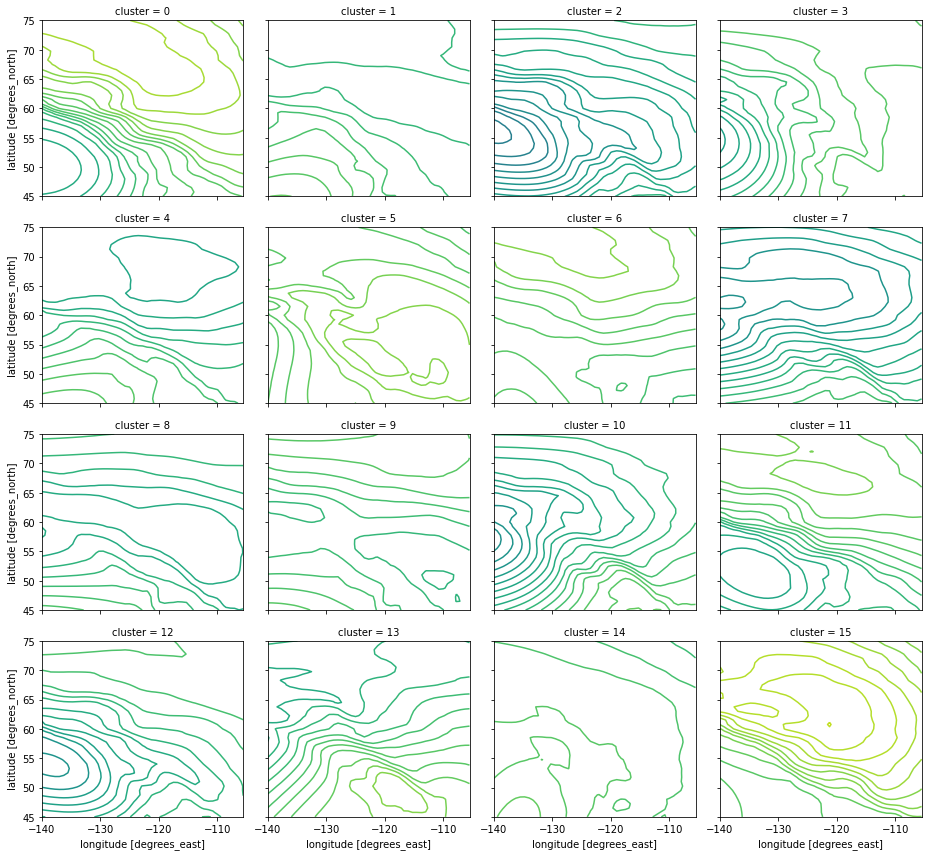

In [104]:
f = clusters['msl'].plot.contour(x='longitude', y='latitude', col='cluster', col_wrap=4, levels=np.arange(940,1050,2))


In [105]:
#sum(nbdays)

27760

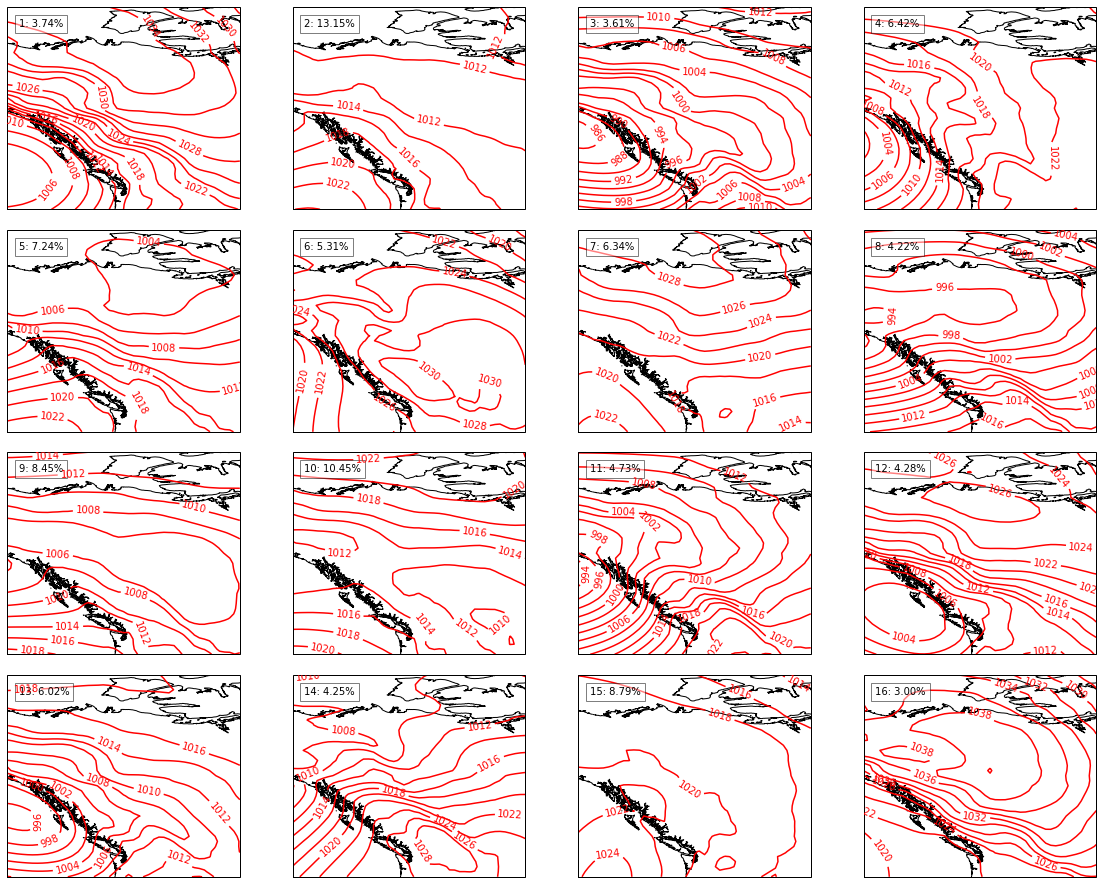

In [106]:
f, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,16), subplot_kw={'projection':proj})
f.subplots_adjust(wspace=0.1, hspace=0.1)
axes = axes.flatten() 
for c in range(nclusters): 
    ax = axes[c]
    levels=np.arange(940,1050,2)
    clus = clusters.sel(cluster=c)
    make_map(clus['msl'], lons, lats, step=2, ax=ax)
    ax.text(0.05, 0.9, "{}: {:3.2f}%".format(c+1, nbdays[c] / sum(nbdays) * 100), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))

In [107]:
f.savefig('desktop/AB_clusters.png', dpi=200)

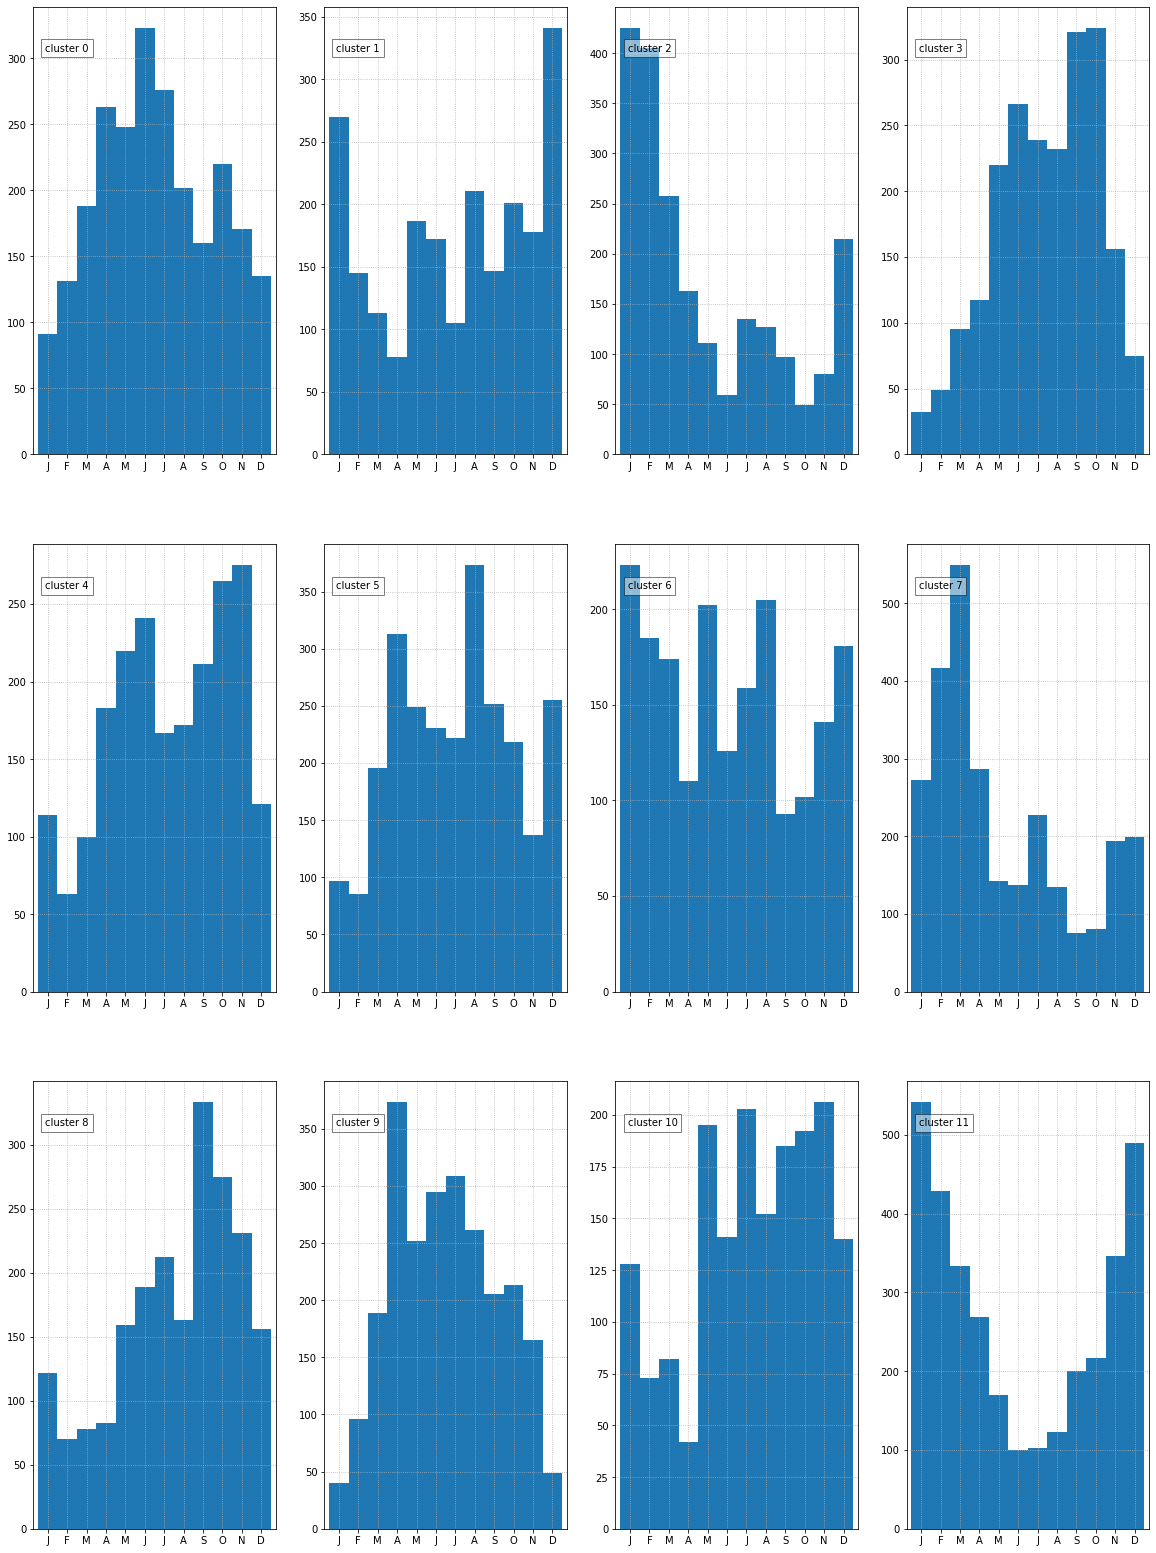

In [411]:
f, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,28))
axes = axes.flatten() 
for c in range(nclusters): 
    ax = axes[c]
    cf = labels.query('cluster == {}'.format(c))
    # in percentage
    ((cf.groupby(cf.index.month).count()) / len(cf) * 100).plot(kind='bar', width=1, ax=ax, legend=None)
    # in number of days
    cf.groupby(cf.index.month).count().plot(kind='bar', width=1, ax=ax, legend=None)
    ax.set_ylim(0, None)
    ax.grid(ls=':')
    ax.text(0.05, 0.9, 'cluster {}'.format(c), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))
    ax.set_xticklabels(list('JFMAMJJASOND'), rotation=0)
    ax.set_xlabel('')